In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import string
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
import numpy as np
from scipy.spatial import distance
import operator
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
#function to find English words

def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [3]:
#load the complete list from imdb

f = pd.read_table('title.basics.tsv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ftype = f['genres']
dc = f.loc[ftype.str.contains('Documentary', na=False)]
#f[f['genres'].str.startswith('Documentary')].index
#dc = f.loc[f['genres'] == ftype]
#f['startYear'][0]

In [5]:
dc.tail()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
5570458,tt9631176,movie,McGurks bar bombing - Loss of Innocence,McGurks bar bombing - Loss of Innocence,0,2012,\N,54,Documentary
5570469,tt9631206,tvShort,Respect Can't Be Beat,Respect Can't Be Beat,0,1993,\N,20,"Documentary,Drama,Short"
5570470,tt9631212,tvEpisode,Noël Coward Theatre,Noël Coward Theatre,0,2012,\N,\N,"Documentary,History"
5570497,tt9631304,movie,The Secret's Out,The Secret's Out,0,2013,\N,51,Documentary
5570522,tt9631364,movie,Market Memories,Market Memories,0,2011,\N,60,Documentary


In [9]:
# get the dataframe containing only the documentary genre with titles in English
dc = f[['tconst', 'primaryTitle', 'startYear']]

dc = dc.reset_index(drop = True)
#this resultant dataframe contains only the 3 columns - title, year and imdb ID


idx = []

for i in range(len(dc)): 
    if isEnglish(str(dc['primaryTitle'][i])) == True:
        idx.append(i)
        
dc = dc.iloc[idx, :].reset_index(drop = True)
    
#print(len(dc[pd.to_numeric(dc['startYear'], errors='coerce').isnull()]))
dc['startYear'] = pd.to_numeric(dc['startYear'], errors='coerce')
#print(len(dc))

if len(dc[dc['startYear'].isnull()].index.tolist()) != 0:
    dc.dropna(inplace=True)
print(dc[dc['startYear'].isnull()].index.tolist())
print(len(dc))

#df.loc[df[pd.to_numeric(df['startYear'], errors='coerce').isnull()]]
dc.head()

[]
4993692


,tconst,primaryTitle,startYear
0,tt0000001,Carmencita,1894.0
1,tt0000002,Le clown et ses chiens,1892.0
2,tt0000003,Pauvre Pierrot,1892.0
3,tt0000004,Un bon bock,1892.0
4,tt0000005,Blacksmith Scene,1893.0


In [10]:
dc['startYear'] = dc['startYear'].astype(int)
dc = dc[(dc['startYear'] >= 1970) & (dc['startYear'] < 2019)]
dc = dc.reset_index(drop = True)
print(len(dc))
dc['description'] = 'none'
dc.head()

4515970


,tconst,primaryTitle,startYear,description
0,tt0015724,Dama de noche,1993,none
1,tt0023331,Pesn o geroyakh,1983,none
2,tt0035423,Kate & Leopold,2001,none
3,tt0036606,"Another Time, Another Place",1983,none
4,tt0039442,"Habla, mudita",1973,none


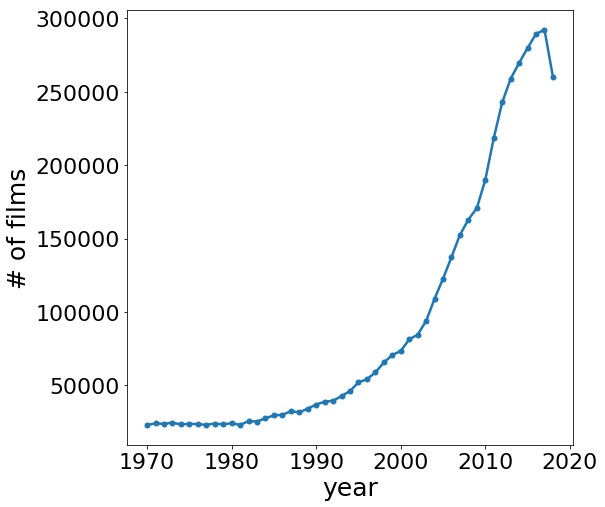

In [11]:
dfyr = dc[['tconst', 'startYear']].groupby('startYear')
plt.figure(figsize=(8,8))
plt.plot(dfyr.startYear.first(), dfyr.tconst.nunique(), '.-',
         linewidth = 2.5, markersize = 10)

axis_font = {'size':'25', 'color':'black'}
axis_tick_font = {'size':'22', 'color':'black'}

plt.xlabel('year', **axis_font)
plt.ylabel('# of films', **axis_font)
plt.xticks(**axis_tick_font)
plt.yticks(**axis_tick_font)
plt.savefig('film_freq.pdf')

In [ ]:
# get the description of the documentaries from IMDB
#start_time = time.time()

for i in range(100000): #restricting to only 100k documentaries
    j = dc['tconst'][i]
    link = requests.get('https://www.imdb.com/title/'+ str(j) + '/plotsummary?ref_=tt_ov_pl')
    soup = BeautifulSoup(link.text, 'html.parser')
    try:
        desc = soup.find('li', class_ = 'ipl-zebra-list__item').find('p').text
        dc['description'][i] = desc
    except:
        pass

#print(time.time() - start_time)

In [ ]:
# save the dataframe, so that I don't lose the information collected
#dc.to_pickle('imdb_desc_all.pkl', index = False, header = True)

In [ ]:
dc.drop(dc[dc['description'].str.startswith('none')].index, inplace = True)
dc.drop(dc[dc['description'].str.startswith('It looks')].index, inplace = True)
dc.drop(dc[dc['description'].str.startswith('httpwww')].index, inplace = True)
dc = dc.reset_index(drop = True)

In [ ]:
# save the dataframe, so that I don't lose the information collected
print(len(dc))
#dc.to_pickle('imdb_desc_all.pkl', index = False, header = True)

In [ ]:
# add urls (just in case)

#dc['links'] = 'none'
#for i in range(len(dc)):
#    j = dc['tconst'][i]
#    dc['links'][i] = 'https://www.imdb.com/title/' + str(j)
#dc.tail()

In [17]:
def clean_data(string_text):
    string_text = string_text.lower()
    string_text = string_text.strip()
    string_text = string_text.translate(string_text.maketrans(' ', ' ', string.punctuation))
    string_text = string_text.replace('\n', ' ')
    string_text = string_text.replace('\t', ' ')
    return string_text

In [ ]:
for i in range(len(dc)):
    dc['description'][i] = clean_data(dc['description'][i])

# save the dataframe, so that I don't lose the information collected
#dc_to.pickle('imdb_desc.pkl', header = True, index = False)

In [18]:
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

In [ ]:
dc['desc_words'] = [[]] * dc.shape[0]

In [ ]:
for i in range(len(dc)):
    sent = preprocess(dc['description'][i])
    dc['desc_words'][i] = list(set([x[0] for x in sent if x[1].startswith('NN')]))

In [ ]:
dc.head()

In [19]:
stwords = stopwords.words('english')
stwords.extend(['film', 'director', 'production', 'documentary', 'movie'])
#stwords[-5:]

In [20]:
def rem_words(string_text):
    sentence = []
    for word in string_text:
        if word.isalpha():
            if word not in stwords:    
                word = WordNetLemmatizer().lemmatize(word)
                sentence.append(word)
    return sentence

In [ ]:
dc['words'] = [[]] * dc.shape[0]

for i in range(len(dc)):
    dc['words'][i] = list(set(rem_words(dc['desc_words'][i])))

In [ ]:
dc['w2v'] = [[]] * dc.shape[0]

In [ ]:
for i in range(len(dc)):
    try:
        dc['w2v'][i] = document_vector(model, ' '.join(dc['words'][i]))
    except:
        pass

In [23]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                   binary=True, limit = 50000)

In [24]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [25]:
link = requests.get('https://www.npr.org/sections/goatsandsoda/2019/02/05/691578203/report-global-warming-could-melt-at-least-a-third-of-himalayan-glaciers')
soup = BeautifulSoup(link.text, 'lxml')


In [26]:
keytags = ''
try:
    page_tags = soup.findAll('div', class_ = 'tags')[0].findAll('li')
    for i in range(len(page_tags)):
        keytags += page_tags[i].text.lower() + ' '
except:
    keytags = soup.find('title').text.replace('NPR', '').split(':')[0] #add the title
keytags

'himalayas glaciers climate change '

In [27]:
newsc_text = ''

for i in range(3, len(soup.findAll('p')) - 2):
        newsc_text += soup.findAll('p')[i].text
#print(newsc_text)

In [28]:
newsc_text = clean_data(newsc_text)
sent = preprocess(newsc_text)
#print(sent)
newsc_data = list(set([x[0] for x in sent if x[1].startswith('NN')]))
#newsc_data.extend(list(set([x[0] for x in sent if x[1].startswith('JJ')])))
newsc_data = rem_words(newsc_data)
newsc_vec = document_vector(model, ' '.join(newsc_data))
#newsc_data

In [29]:
keytags = clean_data(keytags)
sent = preprocess(keytags)
#print(sent)
keytags_data = list(set([x[0] for x in sent if x[1].startswith('NN')]))
#keytags_data.extend(list(set([x[0] for x in sent if x[1].startswith('JJ')])))
print(keytags_data)
keytags_vec = document_vector(model, ' '.join(keytags_data))

['himalayas', 'glaciers', 'change']


In [31]:
cossim = {}
for idx in range(len(dc)):
    cossim[idx] = cosine_similarity(newsc_vec.reshape(1, -1), dc['w2v'][idx].reshape(1, -1))
    #cossim[idx] = cosine_similarity(news_vec.reshape(1, -1), dc['w2v'][idx].reshape(1, -1))
simdoc = sorted(cossim.items(), key = operator.itemgetter(1))

In [35]:
results, key_words, scores = [], [], []

for i in range(len(simdoc)):
    results.append(dc['primaryTitle'][int(simdoc[i][0])])
    key_words.append(dc['desc_words'][int(simdoc[i][0])][:5])

dn = pd.DataFrame({'title': results, 'words': key_words})

In [36]:
dn